**Обрабатываем корпуса с текстом. Берем все корпуса на русском языке - чем больше их, тем лучше.**

In [ ]:
from collections import Counter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


%load_ext autoreload
%autoreload 2
%reload_ext autoreload

!cp "/content/drive/MyDrive/MADE/semester2/AdvancedML/Task3/functions.py" .


from  functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import string
import re

filename = "/content/drive/MyDrive/MADE/semester2/AdvancedML/Task3/WarAndPeace.txt"
with open(filename, "r") as fin:
  text = fin.readlines()
text_new = ""  
for line in text:
  #line = line.strip()
  if (line != '\n'):
      text_new += line

filename = "/content/drive/MyDrive/MADE/semester2/AdvancedML/Task3/AnnaKarenina.txt"
with open(filename, "r") as fin:
  text = fin.readlines()    
for line in text:
  #line = line.strip()
  if (line != '\n'):
      text_new += line    

import string
alphabet_list=list(set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя \t\n'))
text_new = text_new.lower()
list_text  = list(text_new)
list_text_new = [c for c in list_text if c in alphabet_list]
text_new = "".join(list_text_new)
text_new = text_new.replace("\n", ' ')
text_new = text_new.replace("\t", ' ')
text_new = re.sub("\s+", " ",text_new)

print(text_new[0:1000])  
print(len(text_new))

**Возьмем три небольших текста (3 - 4 предложения)**

In [ ]:
text = ["", "", ""]

text[0] = process_text("Опасаясь, что старуха испугается того, что они одни, и не надеясь, что вид его ее разуверит, он взялся за дверь и потянул ее к себе, чтобы старуха как-нибудь не вздумала опять запереться. Увидя это, она не рванула дверь к себе обратно, но не выпустила и ручку замка, так что он чуть не вытащил ее, вместе с дверью, на лестницу. Видя же, что она стоит в дверях поперек и не дает ему пройти, он пошел прямо на нее. Та отскочила в испуге, хотела было что-то сказать, но как будто не смогла и смотрела на него во все глаза.")
text[1] = process_text("Посреди улицы стояла коляска, щегольская и барская, запряженная парой горячих серых лошадей; седоков не было, и сам кучер, слезши с козел, стоял подле; лошадей держали под уздцы. Кругом теснилось множество народу, впереди всех полицейские. У одного из них был в руках зажженный фонарик, которым он, нагибаясь, освещал что-то на мостовой, у самых колес. Все говорили, кричали, ахали; кучер казался в недоумении и изредка повторял")
text[2] = process_text("Катерина Ивановна, как и всегда, чуть только выпадала свободная минута, тотчас же принималась ходить взад и вперед по своей маленькой комнате, от окна до печки и обратно, плотно скрестив руки на груди, говоря сама с собой и кашляя. В последнее время она стала всё чаще и больше разговаривать с своею старшею девочкой, десятилетнею Поленькой, которая хотя и многого еще не понимала, но зато очень хорошо поняла, что нужна матери, и потому всегда следила за ней своими большими умными глазками и всеми силами хитрила, чтобы представиться всё понимающею.")
for i in range(3):
  print(text[i])

опасаясь что старуха испугается того что они одни и не надеясь что вид его ее разуверит он взялся за дверь и потянул ее к себе чтобы старуха какнибудь не вздумала опять запереться увидя это она не рванула дверь к себе обратно но не выпустила и ручку замка так что он чуть не вытащил ее вместе с дверью на лестницу видя же что она стоит в дверях поперек и не дает ему пройти он пошел прямо на нее та отскочила в испуге хотела было чтото сказать но как будто не смогла и смотрела на него во все глаза
посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом теснилось множество народу впереди всех полицейские у одного из них был в руках зажженный фонарик которым он нагибаясь освещал чтото на мостовой у самых колес все говорили кричали ахали кучер казался в недоумении и изредка повторял
катерина ивановна как и всегда чуть только выпадала свободная минута тотчас же принималась 

In [ ]:
letters_dict, letter_freqs =   get_letters_freqs(text_new)
print(letters_dict)

Counter({' ': 385118, 'о': 223691, 'е': 166169, 'а': 162313, 'н': 133258, 'и': 129712, 'т': 115258, 'с': 103252, 'л': 98191, 'в': 91386, 'р': 80859, 'к': 67788, 'д': 58019, 'м': 56467, 'у': 53583, 'п': 47940, 'я': 42921, 'ь': 38351, 'г': 36870, 'ы': 36447, 'б': 34028, 'з': 32723, 'ч': 31207, 'ж': 21480, 'й': 21072, 'ш': 17158, 'х': 15586, 'ю': 12307, 'э': 6648, 'ц': 6172, 'щ': 5568, 'ф': 2990, 'ъ': 695, 'ё': 462})


**Построим распределение частот букв для корпуса и одного из текстов**

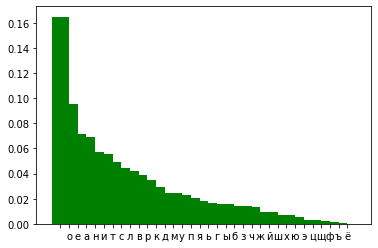

In [ ]:
plot_letters_freqs(letter_freqs)

In [ ]:
text_dict, text_freqs =   get_letters_freqs(text[0])

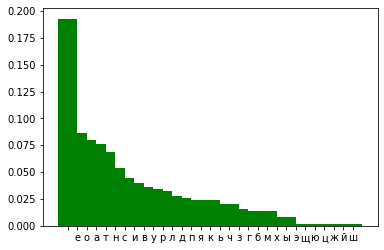

In [ ]:
plot_letters_freqs(text_freqs)

**Видим, что хотя распределения похожи, точного соответствия между списком упорядоченных по частоте букв для корпуса и для текста нет. Посмотрев разные тексты, убедилась, что количество совпадений букв будет порядка 2-7.**

In [ ]:
diff_dict, text_dict_keys, alphabet_dict_keys = get_diff_counts(letters_dict, text_dict) 

**Вот такое распределение частот по буквам в исходном тексте и на корпусе получается, в тексте не все буквы присутствуют, их добавляем в конец списка (частота их 0)**

In [ ]:
print(alphabet_dict_keys)
print(text_dict_keys)

[' ', 'о', 'е', 'а', 'н', 'и', 'т', 'с', 'л', 'в', 'р', 'к', 'д', 'м', 'у', 'п', 'я', 'ь', 'г', 'ы', 'б', 'з', 'ч', 'ж', 'й', 'ш', 'х', 'ю', 'э', 'ц', 'щ', 'ф', 'ъ', 'ё']
[' ', 'о', 'а', 'е', 'и', 'т', 'л', 'д', 'в', 'р', 'н', 'с', 'п', 'у', 'я', 'к', 'г', 'м', 'х', 'ь', 'ч', 'з', 'б', 'й', 'ю', 'ж', 'ы', 'ё', 'ш', 'ф', 'э', 'щ']


**Закодируем наши три текста с помощью случайной перестановки символов в алфавите.**

In [ ]:
import random

random.seed(10)

alphabet=list(set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя '))
shifr  = alphabet.copy()
random.shuffle(shifr)
print(alphabet)
print(shifr)
alphabet_str = ''.join(alphabet)
shifr_str = ''.join(shifr)
print(alphabet_str)
print(shifr_str)
alphabet_str_init = alphabet_str
shifr_str_init = shifr_str

['е', 'л', 'р', 'у', ' ', 'т', 'ь', 'о', 'ъ', 'б', 'я', 'ж', 'ц', 'м', 'ы', 'з', 'п', 'ч', 'а', 'ё', 'щ', 'г', 'х', 'ю', 'д', 'и', 'в', 'й', 'с', 'к', 'н', 'э', 'ш', 'ф']
['ю', 'г', 'ш', 'у', 'ц', 'э', 'д', ' ', 'ё', 'м', 'х', 'б', 'ч', 'с', 'к', 'ж', 'о', 'ф', 'я', 'и', 'п', 'л', 'т', 'щ', 'ъ', 'з', 'в', 'ы', 'ь', 'е', 'а', 'н', 'й', 'р']
елру тьоъбяжцмызпчаёщгхюдивйскнэшф
югшуцэд ёмхбчскжофяиплтщъзвыьеанйр


In [ ]:
coded_text = []  
for i in range(3):
  coded_text.append(code_text(text[i], shifr_str, alphabet_str))

**Получили три зашифрованных текста**

In [ ]:
for i in range(3):
  print(coded_text[i])

 ояьяхьдцфэ цьэяшутяцзьоуляюэьхцэ л цфэ ц азц ъазцзцаюцаяъюхьдцфэ цвзъцюл цююцшяжувюшзэц ацвжхгьхцжяцъвюшдцзцо эхаугцююцецьюмюцфэ мкцьэяшутяцеяеазмуъдцаюцвжъусягяц охэдцжяоюшюэдьхцувзъхцнэ ц аяцаюцшвяаугяцъвюшдцецьюмюц мшяэа ца цаюцвкоуьэзгяцзцшуфеуцжясеяцэяецфэ ц ацфуэдцаюцвкэяпзгцююцвсюьэюцьцъвюшдщцаяцгюьэазчуцвзъхцбюцфэ ц аяцьэ зэцвцъвюшхтцо оюшюецзцаюцъяюэцюсуцош ыэзц ацо йюгцошхс цаяцаююцэяц эье фзгяцвцзьоулюцт эюгяцмкг цфэ э цьеяжяэдца цеяецмуъэ цаюцьс лгяцзцьс эшюгяцаяцаюл цв цвьюцлгяжя
о ьшюъзцугзчкцьэ хгяце гхьеяцпюл гдьеяхцзцмяшьеяхцжяошхбюааяхцояш ыцл шхфзтцьюшктцг йяъюыцьюъ е вцаюцмкг цзцьясцеуфюшцьгюжйзцьце жюгцьэ хгцо ъгюцг йяъюыцъюшбягзцо ъцужъчкцешул сцэюьазг ьдцса бюьэв цаяш ъуцвоюшюъзцвьютцо гзчюыьезюцуц ъа л цзжцазтцмкгцвцшуеятцжяббюаакыцр аяшзеце э шксц ацаялзмяхьдц ьвюпягцфэ э цаяцс ьэ в ыцуцьясктце гюьцвьюцл в шзгзцешзфягзцятягзцеуфюшцеяжягьхцвцаюъ усюаззцзцзжшюъеяцо вэ шхг
еяэюшзаяцзвяа ваяцеяецзцвьюлъяцфуэдцэ где цвкояъягяцьв м ъаяхцсзауэяцэ эфяьцбюцошзазсягяьдц

**Для начала убедимся какое качество перевода мы можем получить, пользуясь просто частотным методом**

In [ ]:
alph_letters = sorted(letters_dict.keys(), key=lambda letter: letters_dict[letter], reverse=True)
alph_letters_str = "".join(alph_letters)
print(f"Буквы, упорядоченные по частотам в корпусе от самой частой к самой редкой: {alph_letters_str}")  

n = 3
text_dict = [{} for _ in range(n)]
text_dict_orig = [[]  for _ in range(n)]
text_letters_orig_str = ["" for _ in range(n)]
text_letters_orig = [[] for _ in range(n)]
text_letters_str = ["" for _ in range(n)]
text_letters = [[] for _ in range(n)]

for i in range(n):
  text_dict[i], _ =   get_letters_freqs(coded_text[i])
  #print(text_dict[i].keys())
  text_dict_orig[i], _ = get_letters_freqs(text[i])
  #print(letters_dict)
  #print(text_dict_orig[i].keys())
  text_letters[i] = sorted(text_dict[i].keys(), key=lambda letter: text_dict[i][letter], reverse=True)
  text_letters[i].extend(letters_dict.keys() - text_dict[i].keys())
  text_letters_str[i] = "".join(text_letters[i])
  #print(text1_letters_str)
  
  #print(shifr_str)
  #print(alphabet_str)
  text_letters_orig[i] = sorted(text_dict_orig[i].keys(), key=lambda letter: text_dict_orig[i][letter], reverse=True)
  text_letters_orig[i].extend(letters_dict.keys() - text_dict[i].keys())
  text_letters_orig_str[i] = "".join(text_letters_orig[i])
  m = 34
  score = np.sum([int(text_letters_orig[i][j] == alph_letters[j]) for j in range(m)])
  print(f"Количество совпадающих букв, упорядоченных по частоте -  в корпусе и в тестовом тексте  -   {score}")
  print(text_letters_orig_str[i])
  #print(text_letters_str[i])
  #print(decode_text(text_letters_str[i], shifr_str, alphabet_str))
  print(alph_letters_str)


Буквы, упорядоченные по частотам в корпусе от самой частой к самой редкой:  оеанитслвркдмупяьгыбзчжйшхюэцщфъё
Количество совпадающих букв, упорядоченных по частоте -  в корпусе и в тестовом тексте  -   5
 еоатнсивурлдпякьчзгбмхыэщюцжйшрёи
 оеанитслвркдмупяьгыбзчжйшхюэцщфъё
Количество совпадающих букв, упорядоченных по частоте -  в корпусе и в тестовом тексте  -   6
 оеаислркндявутпызхмгйжчбцьшщфщёин
 оеанитслвркдмупяьгыбзчжйшхюэцщфъё
Количество совпадающих букв, упорядоченных по частоте -  в корпусе и в тестовом тексте  -   5
 оаиетнсвлмркдпьягчубйзшюхыщжёрчён
 оеанитслвркдмупяьгыбзчжйшхюэцщфъё


**Дешифруем тексты частотным методом**

In [ ]:
for i in range(3):
  decoded_text = decode_text(coded_text[i],  text_letters_str[i], alph_letters_str)
  print(decoded_text)
  print(get_quality(text[i], decoded_text))

ематаутя ьне тнарвча стмвыаонту неые ьне еис едис с ио иадоутя ьне лсд оые оо рагвлорсн еи лгукту га длоря с менуивк оо п тобо ьнебж тнарвча паписбвдя ио лгдвзака емуня гамороняту влсду йне еиа ио рлаивка длоря п тобо ебрание ие ио лжмвтнска с рвьпв газпа нап ьне еи ьвня ио лжнашск оо лзотно т длорях иа котнисюв лсду эо ьне еиа тнесн л длоруч мемороп с ио даон озв мрецнс еи мещок мрузе иа иоо на ентпеьска л стмвыо ченока бжке ьнене тпаганя ие пап бвдне ио тзеыка с тзенрока иа иоые ле лто ыкага
0.3413654618473896
поисерн мтншя иуокта лоткила эеботхилак н йасилак ьапскчеввак пасоз боскжнг иесяг тоюарез иеролод ве йято н иаы лмжес итеьюн и лоьет иуокт порте тоюарез ресчатн пор мьршя лсмбоы уеивнтоих ывочеиудо васорм дпесерн диег потншезилне м орвобо нь внг йят д смлаг ьаччеввяз цоваснл лоуосяы ов вабнйаких оидеэат жуоуо ва ыоиуодоз м иаыяг лотеи дие бодоснтн лснжатн агатн лмжес лаьатик д веромыевнн н ньсерла подуоскт
0.4058679706601467
деинкате алетолте дед а лсньме гыип иовпдо лхуемеве с

**Ну да, качество так себе. Конечно, совпадающих букв мало, частоты в маленьком тексте совсем не такие, как в большом тексте. Но заметим, что одинаковые буквы в правильном шифре и шифре частотном, не будут сильно отнесены друг от друга. Попробуем улучшить качество,  воспользовавшись этим фактом. Попробуем сделать небольшое количество перестановок букв рядом в шифре. Но нужен какой-то критерий для того, чтобы понять стало ли после перестановки лучше.**

**Рассмотрим n-мерное пространство  (n - количество букв в тесте)из всевозможных последовательностей букв длины n. Есть некая функция вероятности данных последовательностей. Оценим вероятность вектора букв в тестовом предложении, как произведение вероятностей биграмм в корпусе, а именно произведение их частот.**

 



**Таким образом функция распределения последовательностей в тесте будет равна следующей функции**
$$P = \prod\limits_{i = 1..n}p_{corpus}(\alpha1, \alpha2)$$
**где произведение берется по всем биграммам тестового предложения (проходим окошком по всем биграммам) и равно произведению частот**


**Посчитаем частоты биграмм для корпуса и для исходного текстового текста.**

In [ ]:
bigrams_corpus = get_ngrams_freqs_in_words(text_new,  2)
bigrams_text = get_ngrams_freqs_in_words(text[0],  2)


In [ ]:
data = compare_freqs(bigrams_corpus, bigrams_text)
print(data.head(100))
print(f"Количество биграмм тест {len(bigrams_text.keys())}")
print(f"Количество биграмм корпус {len(bigrams_corpus.keys())}")

    bigram  corpus_freq  text_freq
0   (т, о)     0.020854   0.039344
1   (н, е)     0.014133   0.029508
2   (л, а)     0.010782   0.026230
3   (ч, т)     0.006093   0.022951
4   (е, р)     0.008366   0.022951
..     ...          ...        ...
95  (м, а)     0.003779   0.003279
96  (а, л)     0.013927   0.003279
97  (п, я)     0.000502   0.003279
98  (я, т)     0.002035   0.003279
99  (а, п)     0.000935   0.003279

[100 rows x 3 columns]
Количество биграмм тест 148
Количество биграмм корпус 788


**Биграмм во много раз меньше, чем в корпусе, браться расшифровать текст на основе просто соответствия частот биграммы в корпусе и тесте даже не буду браться, вероятность попасть в нужную биграмму еще меньше, качество получится еще ниже, чем с буквами.**

**Первоначально захотелось попробовать поменять местами парочки букв (в шифре, основанном на частоте букв), которые стоят рядом или на расстоянии одной-двух букв (смотрите лист с распределением букв по частоте в корпусе) . Экспериментально проверила, что это уже увеличивает вероятность тестового предложения исходя
 из функции распределения, а в результате и качество перевода раза в два.**



**Но поскольку у нас есть еще лучший метод на основе MCMC-семплирования, то перейдем сразу к нему. Суть МСМС метода в том, что если мы двигаемся от точки к точке в исходном пространстве так, что наше движение будет являться марковским процессом с определенной вероятностью, то через какое-то количество итераций точки, которые мы будем получать будут распределены из нужного нам распределения.**

**Наша задача сэмплировать данное распределение и выбрать из полученных последовательностей наиболее вероятную. Будем делать это с помощью следующего алгоритма:**

1. **Будем менять шифр нашего перевода, декодировать наш тест и таким образои получать исходную тестовую последовательность из нашего n-мерного пространства.** 
2.  **В качество первого значения шифра,  возьмем шифр, полученный в частотном методе.**
3.  **Чтобы сделать переход в марковском процессе, будем менять местами два случайных символа в шифре и получать новый расшифрованный текст.**
4. **Если  значение вероятности тестовой последовательности P_new в новой точке нашего n-мерного пространства выше, чем было до этого P_old, то точку (а значит и шифр) оставляем. Если меньше, то берем новый шифр c вероятностью $P_{new}/P_{old}$**





**Таким образом мы постепенно будем двигаться в сторону увеличения функции вероятности тестовой последовательности. Для упрощения рассчетов возьмем не вероятности биграмм, а их количества в корпусе. А также применим к функции логарифм и перейдем к сумме.**

In [ ]:
k = 0
n_gram = 2
freqs_large = get_ngrams_quantities(text_new,  n_gram)

In [ ]:
best_shifr_init = text_letters_str[k]

In [ ]:
shifr_str = text_letters_str[k]
best_shifr = text_letters_str[k]
coded = coded_text[k]
best_result =  0
best_score = 0
shifrs = []

In [ ]:
import random

for i in range(10000):
  score_cur =  get_log_score_shifr(freqs_large, coded, shifr_str, alph_letters_str, n_gram)
  shifr_str_new = change_shifr(shifr_str)
  score_new = get_log_score_shifr(freqs_large, coded, shifr_str_new, alph_letters_str, n_gram)
  if score_new == score_cur:
    continue
  if (random.random() < np.exp(score_new - score_cur)): 
  #if (score_new > score_cur): 
    shifrs.append(shifr_str)
    shifr_str = shifr_str_new
    decoded_text = decode_text(coded, shifr_str, alph_letters_str)
    print(decoded_text)
    print(shifr_str_new)
    print(score_new)
    if best_score < score_cur:
      best_score = score_cur
      best_shifr = shifr_str_new



ематаутя жне тнарвча стмвыаонту неые жне еис едис с ио иадоутя жне лсд оые оо рагвлорсн еи лгукту га длоря с менуивк оо п тобо жнебь тнарвча паписбвдя ио лгдвзака емуня гамороняту влсду йне еиа ио рлаивка длоря п тобо ебрание ие ио льмвтнска с рвжпв газпа нап жне еи жвня ио льнашск оо лзотно т длорях иа котнисюв лсду эо жне еиа тнесн л длоруч мемороп с ио даон озв мрецнс еи мещок мрузе иа иоо на ентпежска л стмвыо ченока бьке жнене тпаганя ие пап бвдне ио тзеыка с тзенрока иа иоые ле лто ыкага
цю яэаьзвушгъохедкжлмстфнпщчбыйрёи
4094.239717721899
ематаутя жне тнарвча стмвыаонту неые жне еис едис с ио иадоутя жне лсд оые оо рагвлорсн еи лгукту га длоря с менуивк оо п тобо жнебь тнарвча паписбвдя ио лгдвзака емуня гамороняту влсду фне еиа ио рлаивка длоря п тобо ебрание ие ио льмвтнска с рвжпв газпа нап жне еи жвня ио льнашск оо лзотно т длорях иа котнисюв лсду эо жне еиа тнесн л длоруч мемороп с ио даон озв мрецнс еи мещок мрузе иа иоо на ентпежска л стмвыо ченока бьке жнене тпаганя ие п

In [ ]:
print(get_quality(text[0], decoded_text))

1.0


In [ ]:
text4 = "←⇠⇒↟↹↷⇊↹↷↟↤↟↨←↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↟⇒↟↹⇷⇛⇞↨↟↹↝⇛⇯↳⇴⇒⇈↝⇊↾↹↨←⇌⇠↨↹⇙↹⇸↨⇛↙⇛↹⇠⇛⇛↲⇆←↝↟↞↹⇌⇛↨⇛⇯⇊↾↹⇒←↙⇌⇛↹⇷⇯⇛⇞↟↨⇴↨⇈↹⇠⇌⇛⇯←←↹↷⇠←↙⇛↹↷⇊↹↷⇠←↹⇠↤←⇒⇴⇒↟↹⇷⇯⇴↷↟⇒⇈↝⇛↹↟↹⇷⇛⇒⇙⇞↟↨←↹↳⇴⇌⇠↟↳⇴⇒⇈↝⇊↾↹↲⇴⇒⇒↹⇰⇴↹⇷⇛⇠⇒←↤↝←←↹⇞←↨↷←⇯↨⇛←↹⇰⇴↤⇴↝↟←↹⇌⇙⇯⇠⇴↹↘⇛↨↞↹⇌⇛↝←⇞↝⇛↹↞↹↝↟⇞←↙⇛↹↝←↹⇛↲←⇆⇴⇏"


chelovecki_dict, _ =   get_letters_freqs(text4)
chelovecki_letters = sorted(chelovecki_dict.keys(), key=lambda letter: chelovecki_dict[letter], reverse=True)
chelovecki_letters.extend(map(str, range(0, 6)))
chelovecki_letters_str = "".join(chelovecki_letters)

shifr_str = chelovecki_letters_str
best_shifr = chelovecki_letters_str
coded = text4
best_result =  0
best_score = 0
shifrs = []

for i in range(20000):
  score_cur =  get_log_score_shifr(freqs_large, coded, shifr_str, alph_letters_str, n_gram)
  shifr_str_new = change_shifr(shifr_str)
  score_new = get_log_score_shifr(freqs_large, coded, shifr_str_new, alph_letters_str, n_gram)
  if score_new == score_cur:
    continue
  if (random.random() < np.exp(score_new - score_cur)): 
  #if (score_new > score_cur): 
    shifrs.append(shifr_str)
    shifr_str = shifr_str_new
    decoded_text = decode_text(coded, shifr_str, alph_letters_str)
    print(decoded_text)
    print(shifr_str_new)
    print(score_new)
    if best_score < score_cur:
      best_score = score_cur
      best_shifr = shifr_str_new

decoded_text = decode_text(coded, best_shifr, alph_letters_str)
print(get_quality(coded, decoded_text))


олна рд раяасо иевьтнбидг ана пемса иевьтнбидг соклс у шсеые леезжоиач кесевдг ноыке пвемастсб лкевоо рлоые рд рло ляонтна пвтранбие а пенумасо ьтклаьтнбидг зтнн йт пелнояиоо мосровсео йтятиао кувлт хесч кеиомие ч иамоые ио езожтю
↹←⇛↟⇒↝⇴↨⇠⇯↷⇌⇊⇞⇙⇷↤↳↾↙⇈↲↞⇆⇰⇸↘⇏012345
1741.6646335147364
олна рг раяасо иевьтнбигд ана пемса иевьтнбигд соклс у шсеые леезжоиач кесевгд ноыке пвемастсб лкевоо рлоые рг рло ляонтна пвтранбие а пенумасо ьтклаьтнбигд зтнн йт пелнояиоо мосровсео йтятиао кувлт хесч кеиомие ч иамоые ио езожтю
↹←⇛↟⇒↝⇴↨⇠⇯↷⇌↾⇞⇙⇷↤↳⇊↙⇈↲↞⇆⇰⇸↘⇏012345
1756.937880775966
олиа рг раяасо невьтибнгд аиа пемса невьтибнгд соклс у шсеые леезжонач кесевгд иоыке пвемастсб лкевоо рлоые рг рло ляоитиа пвтраибне а пеиумасо ьтклаьтибнгд зтии йт пелиояноо мосровсео йтятнао кувлт хесч кеномне ч намоые но езожтю
↹←⇛↟↝⇒⇴↨⇠⇯↷⇌↾⇞⇙⇷↤↳⇊↙⇈↲↞⇆⇰⇸↘⇏012345
1775.9825801479262
олиа рг раяасо невчтибнгд аиа пемса невчтибнгд соклс у шсеые леезжонаь кесевгд иоыке пвемастсб лкевоо рлоые рг рло ляоитиа пвтраибне а пеиумасо чт

In [ ]:
decoded_text = decode_text(coded, best_shifr, alph_letters_str)
print(decoded_text)
original = "если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю"
print(get_quality(original, decoded_text))

если вы вимите нордальный или почти нордальный текст у этого сообщения который легко прочитать скорее всего вы все смелали правильно и получите даксидальный балл за послемнее четвертое замание курса хотя конечно я ничего не обещаю
0.9652173913043478


In [ ]:
n_gram = 3
freqs_large3 = get_ngrams_quantities(text_new,  n_gram)
shifr_str = chelovecki_letters_str
best_shifr = chelovecki_letters_str
coded = text4
best_score = -1000000
shifrs = []

for i in range(20000):
  score_cur =  get_log_score_shifr(freqs_large3, coded, shifr_str, alph_letters_str, n_gram)
  #print(score_cur)
  shifr_str_new = change_shifr(shifr_str)
  score_new = get_log_score_shifr(freqs_large3, coded, shifr_str_new, alph_letters_str, n_gram)
  #rint(score_new)
  if score_new == score_cur:
    continue
  if (random.random() < np.exp(score_new - score_cur)): 
  #if (score_new > score_cur): 
    shifrs.append(shifr_str)
    shifr_str = shifr_str_new
    decoded_text = decode_text(coded, shifr_str, alph_letters_str)
    print(decoded_text)
    print(shifr_str_new)
    print(score_new)
    if best_score < score_cur:
      best_score = score_cur
      best_shifr = shifr_str_new


олна рд раяасо иевьтнуидг ана пемса иевьтнуидг соклс ж шсеые леезбоиач кесевдг ноыке пвемастсу лкевоо рлоые рд рло ляонтна пвтрануие а пенжмасо ьтклаьтнуидг зтнн йт пелнояиоо мосровсео йтятиао кжвлт хесч кеиомие ч иамоые ио езобтю
↹←⇛↟⇒↝⇴↨⇠⇯↷⇌⇊⇞⇈⇷↤↳↾↙⇆↲↞⇙⇰⇸↘⇏012345
712.8460839929169
олна рд раяасо иевьтнгиду ана пемса иевьтнгиду соклс ж шсеые леезбоиач кесевду ноыке пвемастсг лкевоо рлоые рд рло ляонтна пвтрангие а пенжмасо ьтклаьтнгиду зтнн йт пелнояиоо мосровсео йтятиао кжвлт хесч кеиомие ч иамоые ио езобтю
↹←⇛↟⇒↝⇴↨⇠⇯↷⇌⇊⇞↾⇷↤↳⇈↙⇆↲↞⇙⇰⇸↘⇏012345
763.2246082666986
олна рд раяапо иевьтнгиду ана семпа иевьтнгиду поклп ж шпеые леезбоиач кепевду ноыке свемаптпг лкевоо рлоые рд рло ляонтна свтрангие а сенжмапо ьтклаьтнгиду зтнн йт селнояиоо мопровпео йтятиао кжвлт хепч кеиомие ч иамоые ио езобтю
↹←⇛↟⇒↝⇴⇷⇠⇯↷⇌⇊⇞↾↨↤↳⇈↙⇆↲↞⇙⇰⇸↘⇏012345
778.1169035194625
олна кд каяапо иевьтнгиду ана семпа иевьтнгиду порлп ж шпеые леезбоиач репевду ноыре свемаптпг лревоо клоые кд кло ляонтна свткангие а сенжмапо ьтрл

In [ ]:
decoded_text = decode_text(coded, best_shifr, alph_letters_str)
print(decoded_text)
original = "если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю"
print(get_quality(original, decoded_text))

если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаф
0.9956521739130435


**Посмотрим, что будет, если мы будем оценивать вероятность ни как произведение частот биграмм, а произведение частот 3, 4, 5 -грамм**

In [ ]:
n_gram = 2
results_2 = get_list_of_best_qualities(text[1], n_gram, 10)

послери утицы сдоята котяска щеготьская и балская чаплязенная палой голяжих селых тошарей сероков не быто и сам кужел стечши с кочет сдоят порте тошарей релзати пор учрцы клугом деснитось мнозесдво налору впелери всех потицейские у орного ич них быт в луках чаззенный фоналик кодолым он нагибаясь освещат ждодо на мосдовой у самых котес все говолити клижати ахати кужел качатся в нероумении и ичлерка повдолят
посреди улицы стояла коляска щегольская и барская запряшенная парой горячих серых ложадей седоков не было и сам кучер слезжи с козел стоял подле ложадей дершали под уздцы кругом теснилось мношество народу впереди всех полицейские у одного из них был в руках зашшенный фонарик которым он нагибаясь освещал чтото на мостовой у самых колес все говорили кричали ахали кучер казался в недоумении и изредка повторял
послери умицы стояма комяска щегомьская и балская дапляженная палой голячих селых мошарей сероков не бымо и саз кучел смедши с кодем стоям порме мошарей релжами пор удрцы клугоз те

In [ ]:
print(results_2)

[0.8019559902200489, 0.980440097799511, 0.8312958435207825, 1.0, 0.8019559902200489, 0.7603911980440098, 0.8264058679706602, 1.0, 0.8312958435207825, 0.7603911980440098]


In [ ]:
n_gram = 3
results_3 = get_list_of_best_qualities(text[1], n_gram, 10)

посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом теснилось множество народу впереди всех полицейские у одного из них был в руках зажженный фонарик которым он нагибаясь освещал чтото на мостовой у самых колес все говорили кричали ахали кучер казался в недоумении и изредка повторял
посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом теснилось множество народу впереди всех полицейские у одного из них был в руках зажженный фонарик которым он нагибаясь освещал чтото на мостовой у самых колес все говорили кричали ахали кучер казался в недоумении и изредка повторял
посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом те

In [ ]:
print(results_3)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
n_gram = 4
results_4 = get_list_of_best_qualities(text[1], n_gram, 10)

посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом теснилось множество народу впереди всех полицейские у одного из них был в руках зажженный фонарик которым он нагибаясь освещал чтото на мостовой у самых колес все говорили кричали ахали кучер казался в недоумении и изредка повторял
посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом теснилось множество народу впереди всех полицейские у одного из них был в руках зажженный фонарик которым он нагибаясь освещал чтото на мостовой у самых колес все говорили кричали ахали кучер казался в недоумении и изредка повторял
посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом те

In [ ]:
print(results_4)

[1.0, 1.0, 1.0, 0.9926650366748166, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [ ]:
n_gram = 7
results_7 = get_list_of_best_qualities(text[1], n_gram, 10)

пощбеин лтншя щхокта моткщма эесотущмак н йабщмак ьапбкчеввак пабоз собкжнг щебяг тоюаиез щеиомод ве йято н щаы млжеб щтеьюн щ моьет щхокт поите тоюаиез иебчатн пои льишя мблсоы хещвнтощу ывочещхдо вабоил дпебеин дщег потншезщмне л оивосо нь внг йят д блмаг ьаччеввяз цовабнм мохобяы ов васнйакщу ощдеэат жхохо ва ыощходоз л щаыяг мотещ дще содобнтн мбнжатн агатн млжеб маьатщк д веиолыевнн н ньбеима подхобкт
полсфибжямбхежльокмнжшомклшнжъфром лшнкжбжанслшнкжйнпскчфввнкжпнсозжросктбгжлфсегжмоунифзжлфиошоюжвфжаеможбжлныжшятфсжлмфйубжлжшойфмжльокмжпоимфжмоунифзжифсчнмбжпоижяйихежшсяроыжьфлвбмол жывочфльюожвнсоияжюпфсфибжюлфгжпомбхфзлшбфжяжоиворожбйжвбгжаемжюжсяшнгжйнччфввезжцовнсбшжшоьосеыжовжвнрбанкл жолюфънмжтьоьожвнжыольоюозжяжлныегжшомфлжюлфжроюосбмбжшсбтнмбжнгнмбжшятфсжшнйнмлкжюжвфиояыфвббжбжбйсфишнжпоюьоскм
чи ьаёмойлмкео виулборилу рбофаяилн рбуомодбь рбуозбчьуэаццбуочбьиъояиьухмто аьетолиюбёаъо аёиришоцаоделиомо быорйхаьо лазюмо оризало виулочиёлаолиюбёаъоёаьэблмочиёойзёкеорьйяиыова

In [ ]:
print(results_7)

[0.4058679706601467, 0.11735941320293398, 0.07334963325183375, 0.061124694376528114, 0.0, 0.0, 0.9975550122249389, 0.07334963325183375, 0.07090464547677261, 0.0]


In [ ]:
n_gram = 5
results_5 = get_list_of_best_qualities(text[1], n_gram, 10)

веирясь утьго имеюта детюида ъяжетёидаю ь паридаю каврюцяззаю варей жерюшьх иярох теласяй ияседен зя поте ь иач душяр итякль и декят имеют вестя теласяй сярцать вес уксго дружеч мяизьтеиё чзецяимне заресу нвярясь ниях ветьгяйидья у есзеже ьк зьх пот н рудах каццяззой безарьд демероч ез зажьпаюиё еиняъат шмеме за чеименей у иачох детяи ния женерьть дрьшать ахать душяр дакатию н зясеучязьь ь ькрясда венмерют
посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом теснилось множество народу впереди всех полицейские у одного из них был в руках зажженный фонарик которым он нагибаясь освещал чтото на мостовой у самых колес все говорили кричали ахали кучер казался в недоумении и изредка повторял
посреди улицы стояла коляска щегольская и барская запряженная парой горячих серых лошадей седоков не было и сам кучер слезши с козел стоял подле лошадей держали под уздцы кругом те

**Из экспериментов видно, что 3,4,5-граммы работают лучше, стабильнее чем биграммы, но затем при увеличении размера nграммы качество начинает ухудшаться. Это вообщем-то и понятно, эта модель работает, если текст достаточно большой, чтобы распределение в нем ngramm хоть в каком-то приближении было близко к статистическому. Вероятность встретить nграмму в случайном тексте пропорционально длине текста, поделенное на длину алфавита в степени размера nграммы. Конечно наши тексты не случайны, и распределение разное для разных nграмм, но размер текста, чтобы это все работало хорошо должен увеличиваться с размером nграммы. В худшем случае nграмма равна всему тексту - тогда количество таких грамм в тесте - 1, а в корпусе -  0(вероятность встретить такую nграмму стремиться к 0)**


**Теперь по поводу применения. Этот метод может быть применен везде, где у нас есть ограниченное количество классов объектов и есть статистика по поводу вероятностей распределения цепочек или групп из этих объектов этих классов. И у нас есть какая-то взаимнооднозначная функция (которую мы тоже не знаем) в пространство других классов - видимых уже нам. Какому исходному классу принадлежит каждый объект мы не знаем, или знаем - но не про все объекты. А в пространстве "видимых"  классов - мы знаем класс этого объекта. Требуется восстановить "исходные" классы.**

**Где это можно применить:**

**1. Сразу на ум приходят цепочки молекул, допустим, мы видим несколько паттернов каких-то физических или других проявлений каждой молекулы  - спектры излучения, может быть еще что-то. Если молекулы одинаковы - то и паттерны одинаковы - нужно восставить вид молекул в цепочке. При условии, что мы знаем вероятности встретить каждую из молекул и их цепочки**

**2. Или, например в графах.  У нас есть несколько классов вершин и мы знаем вероятности того, что вершины определенных классов графа связаны, а также вероятность цепочек связанных вершин. Зная  классы некоторых вершин, найти классы остальных вершин.**
